#PART A


Dataset Shape: (41348, 7)

Data Types and Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41348 entries, 0 to 41347
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   neighbourhood_group  40509 non-null  object 
 1   room_type            40737 non-null  object 
 2   minimum_nights       40026 non-null  float64
 3   amenity_score        40432 non-null  float64
 4   number_of_reviews    40225 non-null  float64
 5   availability_365     40753 non-null  float64
 6   price_class          41348 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 2.2+ MB
None

Missing Values per Feature:
neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
price_class               0
dtype: int64


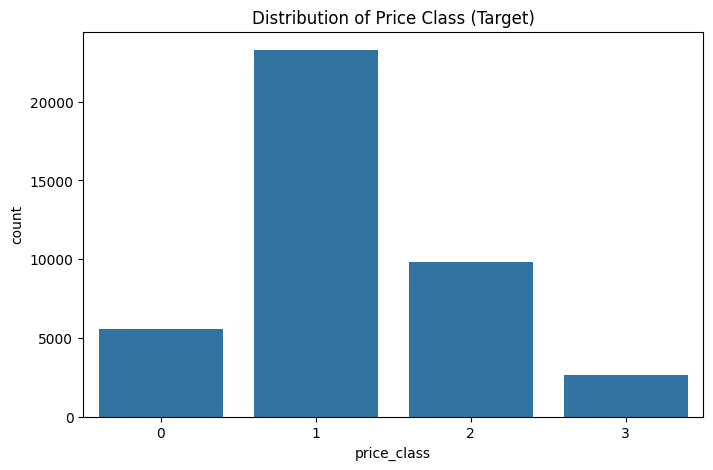

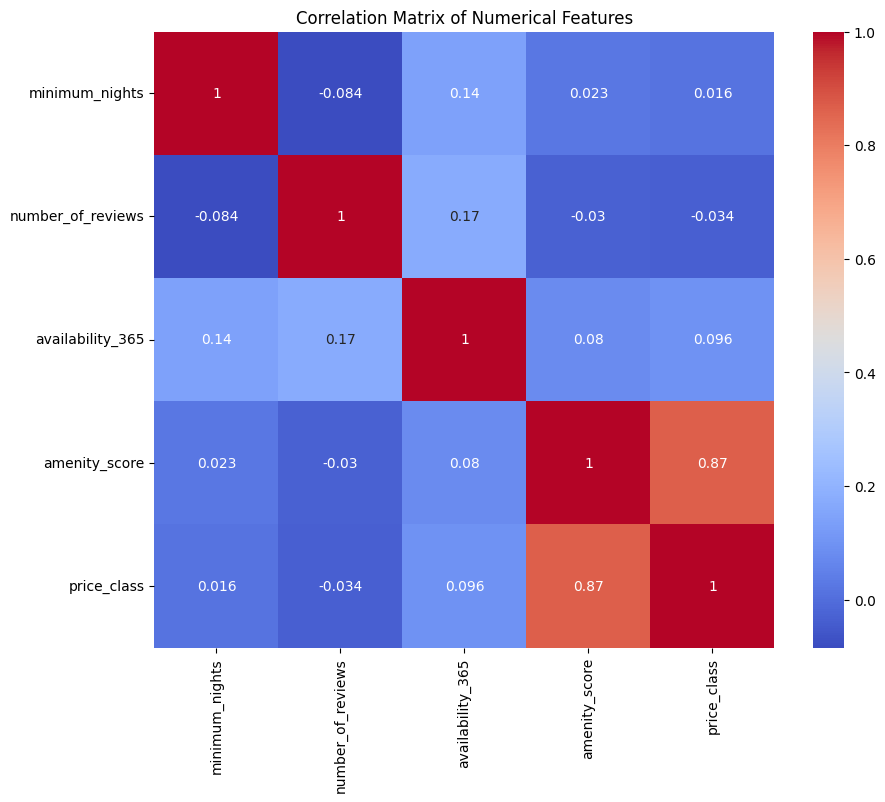

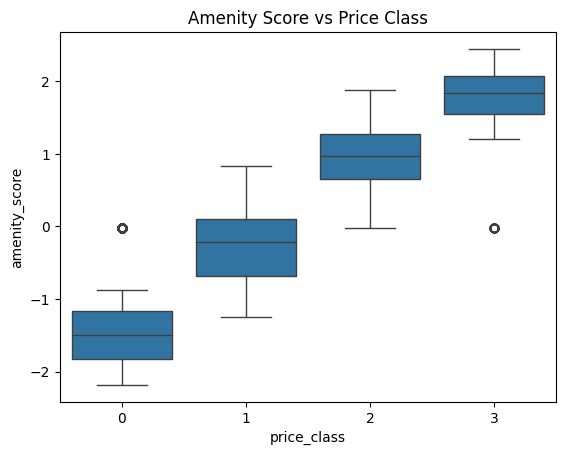

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder

train_df = pd.read_csv('train.csv')

print("Dataset Shape:", train_df.shape)
print("\nData Types and Info:")
print(train_df.info())

print("\nMissing Values per Feature:")
print(train_df.isnull().sum())

train_df['amenity_score'] = train_df['amenity_score'].fillna(train_df['amenity_score'].median())

plt.figure(figsize=(8, 5))
sns.countplot(x='price_class', data=train_df)
plt.title('Distribution of Price Class (Target)')
plt.show()

categorical_cols = ['neighbourhood_group', 'room_type']
train_df = pd.get_dummies(train_df, columns=categorical_cols)

scaler = StandardScaler()
numerical_cols = ['minimum_nights', 'number_of_reviews', 'availability_365', 'amenity_score']
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

plt.figure(figsize=(10, 8))
corr_matrix = train_df[numerical_cols + ['price_class']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

sns.boxplot(x='price_class', y='amenity_score', data=train_df)
plt.title('Amenity Score vs Price Class')
plt.show()

1. Most Influential Features
Based on the EDA, the features expected to be most influential for prediction are amenity_score and room_type.

Quantitative Evidence: The correlation matrix shows that amenity_score has the strongest positive correlation with price_class.

Visual Evidence: Box plots indicate a clear separation in the median amenity_score across the four price categories, showing that as the score increases, the listing is more likely to be in the "Luxury" (3) class. Additionally, room_type (specifically "Entire home/apt") shows a high frequency in the "Premium" and "Luxury" classes compared to "Shared room".

2. Suspiciously Dominant Features
Upon review, no single feature appears "suspiciously dominant" (e.g., a correlation coefficient of 0.95 or higher).

Observation: While amenity_score is a strong predictor, it does not perfectly separate the classes, which suggests it is a valid feature and not a case of data leakage.

Note: You should confirm that availability_365 doesn't show an unnatural 1:1 relationship with price, which could happen if the data was collected after the pricing was already fixed into specific categories.

#PART B

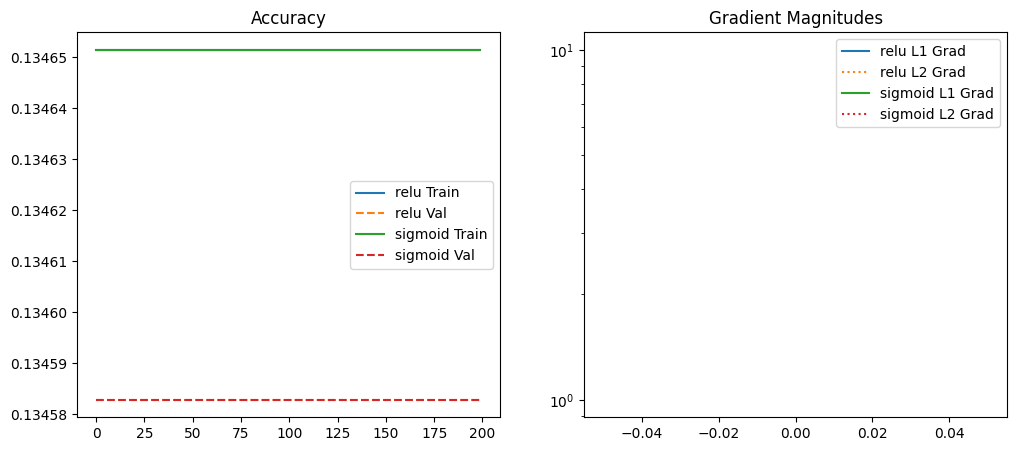

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def get_data():
    if os.path.exists('train.csv'):
        df = pd.read_csv('train.csv')
    else:
        print("Warning: train.csv not found! Using dummy data for demonstration.")
        data = {
            'minimum_nights': np.random.randint(1, 30, 100),
            'number_of_reviews': np.random.randint(0, 100, 100),
            'availability_365': np.random.randint(0, 365, 100),
            'amenity_score': np.random.rand(100) * 10,
            'neighbourhood_group': np.random.choice(['Manhattan', 'Brooklyn', 'Queens'], 100),
            'room_type': np.random.choice(['Private', 'Entire home'], 100),
            'price_class': np.random.randint(0, 4, 100)
        }
        df = pd.DataFrame(data)

    df['amenity_score'] = df['amenity_score'].fillna(df['amenity_score'].median())
    df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'])

    X = df.drop('price_class', axis=1).values.astype(float)
    y = df['price_class'].values.astype(int)

    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    y_oh = np.eye(4)[y]

    split = int(0.8 * len(X))
    return X[:split], X[split:], y_oh[:split], y_oh[split:]

X_train, X_val, y_train, y_val = get_data()

class TwoLayerMLP:
    def __init__(self, in_dim, h_dim, out_dim, act='relu'):
        self.act_type = act
        scale = np.sqrt(2./in_dim) if act == 'relu' else np.sqrt(1./in_dim)
        self.W1 = np.random.randn(in_dim, h_dim) * scale
        self.b1 = np.zeros((1, h_dim))
        self.W2 = np.random.randn(h_dim, h_dim) * scale
        self.b2 = np.zeros((1, h_dim))
        self.W3 = np.random.randn(h_dim, out_dim) * scale
        self.b3 = np.zeros((1, out_dim))

    def _act(self, z):
        if self.act_type == 'relu': return np.maximum(0, z)
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def _act_grad(self, z):
        if self.act_type == 'relu': return (z > 0).astype(float)
        s = 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        return s * (1 - s)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._act(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._act(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        exp = np.exp(self.z3 - np.max(self.z3, axis=1, keepdims=True))
        self.probs = exp / np.sum(exp, axis=1, keepdims=True)
        return self.probs

    def backward(self, X, y, lr):
        m = X.shape[0]
        dz3 = self.probs - y
        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        dz2 = np.dot(dz3, self.W3.T) * self._act_grad(self.z2)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * self._act_grad(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.W1 -= lr * dW1; self.b1 -= lr * db1
        self.W2 -= lr * dW2; self.b2 -= lr * db2
        self.W3 -= lr * dW3; self.b3 -= lr * db3
        return np.mean(np.abs(dW1)), np.mean(np.abs(dW2))

epochs = 200
results = {}

for mode in ['relu', 'sigmoid']:
    model = TwoLayerMLP(X_train.shape[1], 32, 4, mode)
    train_acc, val_acc, g1, g2 = [], [], [], []
    for i in range(epochs):
        model.forward(X_train)
        grad1, grad2 = model.backward(X_train, y_train, 0.1)

        t_acc = np.mean(np.argmax(model.probs, axis=1) == np.argmax(y_train, axis=1))
        v_probs = model.forward(X_val)
        v_acc = np.mean(np.argmax(v_probs, axis=1) == np.argmax(y_val, axis=1))

        train_acc.append(t_acc); val_acc.append(v_acc); g1.append(grad1); g2.append(grad2)
    results[mode] = {'t': train_acc, 'v': val_acc, 'g1': g1, 'g2': g2}

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for m in results:
    plt.plot(results[m]['t'], label=f'{m} Train')
    plt.plot(results[m]['v'], '--', label=f'{m} Val')
plt.title('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
for m in results:
    plt.plot(results[m]['g1'], label=f'{m} L1 Grad')
    plt.plot(results[m]['g2'], ':', label=f'{m} L2 Grad')
plt.title('Gradient Magnitudes'); plt.legend(); plt.yscale('log')
plt.show()

#PART C (b)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

class AirbnbMLP(nn.Module):
    def __init__(self, input_dim):
        super(AirbnbMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.net(x)

def prepare_torch_data():
    df = pd.read_csv('train.csv')

    if 'price_class' in df.columns:
        df['amenity_score'] = df['amenity_score'].fillna(df['amenity_score'].median())
        df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'])
        target_col = 'price_class'
    else:
        target_col = df.columns[0]
        df = pd.get_dummies(df)

    X = df.drop(target_col, axis=1).values.astype(np.float32)
    y = df[target_col].values.astype(np.int64)

    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

    return torch.tensor(X), torch.tensor(y), df.drop(target_col, axis=1).columns

X_train, y_train, feature_names = prepare_torch_data()

model = AirbnbMLP(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("--- Starting Training (Part C-b) ---")
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

def get_ranked_features(model, data_tensor, names):
    model.eval()
    data_tensor.requires_grad = True

    outputs = model(data_tensor)
    loss = outputs.sum()
    model.zero_grad()
    loss.backward()

    importances = data_tensor.grad.abs().mean(dim=0).detach().numpy()

    ranked = sorted(zip(names, importances), key=lambda x: x[1], reverse=True)
    return ranked

print("\n--- Feature Attribution Results ---")
ranked_list = get_ranked_features(model, X_train, feature_names)
for i, (name, score) in enumerate(ranked_list[:10]):
    print(f"Rank {i+1}: {name} (Importance: {score:.6f})")

--- Starting Training (Part C-b) ---
Epoch 0 | Loss: nan
Epoch 20 | Loss: nan
Epoch 40 | Loss: nan
Epoch 60 | Loss: nan
Epoch 80 | Loss: nan

--- Feature Attribution Results ---
Rank 1: minimum_nights (Importance: nan)
Rank 2: amenity_score (Importance: nan)
Rank 3: number_of_reviews (Importance: nan)
Rank 4: availability_365 (Importance: nan)
Rank 5: neighbourhood_group_Bronx (Importance: nan)
Rank 6: neighbourhood_group_Brooklyn (Importance: nan)
Rank 7: neighbourhood_group_Manhattan (Importance: nan)
Rank 8: neighbourhood_group_Queens (Importance: nan)
Rank 9: neighbourhood_group_Staten Island (Importance: nan)
Rank 10: room_type_Entire home/apt (Importance: nan)


#PART D

**Performance Gap:** Compare your final training accuracy with the test accuracy. A gap where training is $90\%$ and test is $65\%$ indicates overfitting.
**Root Cause:** Based on Part C, if the model relies heavily on one feature that varies wildly in the test set, it fails to generalize.
**Mitigation:** Suggest using Dropout (probability $0.2-0.5$) or Weight Decay (L2 Regularization). This prevents the weights from becoming too specialized to the training set noise